# Ensemble Learning & Hyperparameter Tuning

> **Untuk mempermudah, pada notebook ini tidak ada penanganan outlier dan penanganan nilai yang hilang. Tujuan dari notebook ini hanyalah untuk mendemonstrasikan cara menggunakan Hyperparameter Tuning.**

Untuk tutorial ini, kami akan menggunakan kumpulan data yang berisi demografi tentang pelanggan dan apakah pelanggan tersebut membeli produk dari iklan atau tidak.

# A. Data Loading & Preprocessing

In [ ]:
# Import Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score

In [ ]:
# Data Loading

ads_df = pd.read_csv('https://raw.githubusercontent.com/FTDS-learning-materials/phase-1/master/w1/P1W1D4PM%20-%20Social%20Network%20Ads.csv')
ads_df

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0
...,...,...,...
395,46,41000,1
396,51,23000,1
397,50,20000,1
398,36,33000,0


In [ ]:
ads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Age              400 non-null    int64
 1   EstimatedSalary  400 non-null    int64
 2   Purchased        400 non-null    int64
dtypes: int64(3)
memory usage: 9.5 KB


In [ ]:
ads_df['Purchased'].value_counts()

0    257
1    143
Name: Purchased, dtype: int64

In [ ]:
ads_df['Purchased'].value_counts(normalize=True)

0    0.6425
1    0.3575
Name: Purchased, dtype: float64

In [ ]:
# Splitting between `X` and `y`

X = ads_df.drop(['Purchased'], axis=1)
y = ads_df['Purchased']
X

,Age,EstimatedSalary
0,19,19000
1,35,20000
2,26,43000
3,27,57000
4,19,76000
...,...,...
395,46,41000
396,51,23000
397,50,20000
398,36,33000


In [ ]:
# Splitting Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

print('Train size : ', X_train.shape)
print('Test size  : ', X_test.shape)

Train size :  (300, 2)
Test size  :  (100, 2)


In [ ]:
# Feature Scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# B. Baseline Model

Baseline Model adalah model yang dilatih menggunakan parameter default.

### B.1 Bagging - Random Forest

In [ ]:
# Baseline Model menggunakan Random Forest

rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [ ]:
y_train.value_counts()

0    188
1    112
Name: Purchased, dtype: int64

F1 Score - Train Set  :  0.9910714285714286 

Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       188
           1       0.99      0.99      0.99       112

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300
 

Confusion Matrix      : 


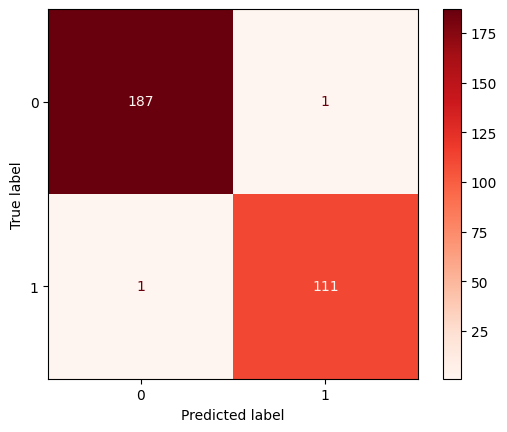

In [ ]:
# Check Performance Model dari Train-Set

y_pred_train = rf.predict(X_train_scaled)

print('F1 Score - Train Set  : ', f1_score(y_train, y_pred_train), '\n')
print('Classification Report : \n', classification_report(y_train, y_pred_train), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(rf, X_train_scaled, y_train, cmap='Reds'))

In [ ]:
tn, fp, fn, tp= confusion_matrix(y_train,y_pred_train).ravel()
print('true negative', tn)
print('true positve', tp)

true negative 187
true positve 111


### B.2 Boosting - AdaBoost

Di Scikit-Learn, estimator dasar untuk boosting adalah Decision Tree. Tapi, kita bisa mengubahnya ke algoritma lain.

In [ ]:
# Model Training - AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    estimator= LogisticRegression(random_state=42),
    n_estimators=50,
    random_state=42)
ada_clf.fit(X_train_scaled, y_train)

AdaBoostClassifier(estimator=LogisticRegression(random_state=42),
                   random_state=42)

F1 Score - Train Set  :  0.7524752475247526 

Classification Report : 
               precision    recall  f1-score   support

           0       0.83      0.93      0.87       188
           1       0.84      0.68      0.75       112

    accuracy                           0.83       300
   macro avg       0.84      0.80      0.81       300
weighted avg       0.83      0.83      0.83       300
 

Confusion Matrix      : 


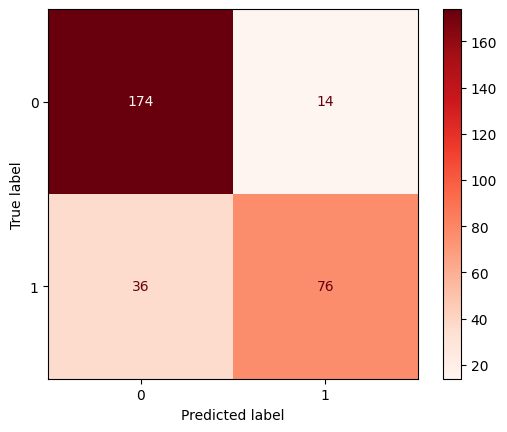

In [ ]:
# Check Performance Model dari Train-Set

y_pred_train = ada_clf.predict(X_train_scaled)

print('F1 Score - Train Set  : ', f1_score(y_train, y_pred_train), '\n')
print('Classification Report : \n', classification_report(y_train, y_pred_train), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(ada_clf, X_train_scaled, y_train, cmap='Reds'))

# C. Cross Validation

Wow ! Model kita baik Random Forest maupun Adaboost mencapai 99% pada Skor F1 untuk train-set.

* Apakah ini hanya kebetulan?
* Apakah skor ini valid?
* Bagaimana jika model mendapatkan data yang mudah dipelajari pada train-set sementara pada test-set berisi data yang sulit dipelajari/diprediksi?

Untuk menjawab pertanyaan ini, kita akan menggunakan Cross Validation. Cross Validation secara sistematis membuat dan mengevaluasi beberapa model pada beberapa subset dari dataset.



### C.1 Random Forest

In [ ]:
# Cross Validation menggunakan `cross_val_score`

%%time
from sklearn.model_selection import cross_val_score

f1_train_cross_val = cross_val_score(rf, #menggunakan random forest
                                     X_train_scaled,
                                     y_train,
                                     cv=3,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.85714286 0.83333333 0.80519481]
F1 Score - Mean - Cross Validation :  0.8318903318903318
F1 Score - Std - Cross Validation  :  0.021232235165313373
F1 Score - Range of Test-Set       :  0.8106580967250184 - 0.8531225670556452
CPU times: user 666 ms, sys: 0 ns, total: 666 ms
Wall time: 669 ms


F1 Score - Test Set   :  0.8656716417910448 

Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93        69
           1       0.81      0.94      0.87        31

    accuracy                           0.91       100
   macro avg       0.89      0.92      0.90       100
weighted avg       0.92      0.91      0.91       100
 

Confusion Matrix      : 


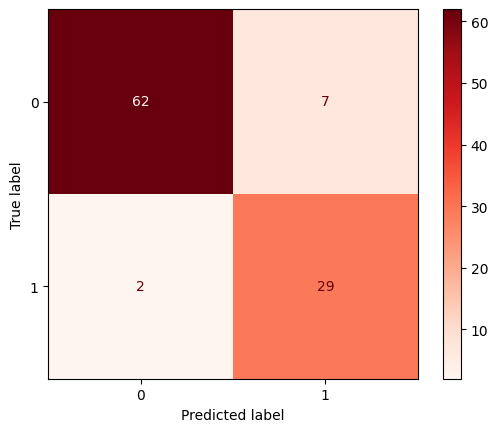

In [ ]:
# Check Performance Model pada Test-Set

y_pred_test = rf.predict(X_test_scaled)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(rf, X_test_scaled, y_test, cmap='Reds'))

In [ ]:
# Save Classification Report kedalam Dictionary

all_reports = {}
def performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, name):
  score_reports = {
      'train - precision' : precision_score(y_train, y_pred_train),
      'train - recall' : recall_score(y_train, y_pred_train),
      'train - accuracy' : accuracy_score(y_train, y_pred_train),
      'train - f1_score' : f1_score(y_train, y_pred_train),
      'test - precision' : precision_score(y_test, y_pred_test),
      'test - recall' : recall_score(y_test, y_pred_test),
      'test - accuracy_score' : accuracy_score(y_test, y_pred_test),
      'test - f1_score' : f1_score(y_test, y_pred_test),
  }
  all_reports[name] = score_reports
  return all_reports

all_reports = performance_report(all_reports, y_train, y_pred_train,
                                 y_test, y_pred_test, 'Baseline RF (Default Hyperparameter)')
pd.DataFrame(all_reports)

,Baseline RF (Default Hyperparameter)
test - accuracy_score,0.910000
test - f1_score,0.865672
test - precision,0.805556
test - recall,0.935484
train - accuracy,0.833333
train - f1_score,0.752475
train - precision,0.844444
train - recall,0.678571


Mean dan Standard Deviation dapat digunakan untuk memberikan interval kepercayaan pada kinerja yang diharapkan pada prosedur pembelajaran mesin.

### C.2 AdaBoost

In [ ]:
# Cross Validation using `cross_val_score`

%%time
f1_train_cross_val = cross_val_score(ada_clf, #menggunakan adaboost
                                     X_train_scaled,
                                     y_train,
                                     cv=3,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.76470588 0.72131148 0.69565217]
F1 Score - Mean - Cross Validation :  0.7272231772252735
F1 Score - Std - Cross Validation  :  0.028499296202907462
F1 Score - Range of Test-Set       :  0.698723881022366 - 0.755722473428181
CPU times: user 747 ms, sys: 255 µs, total: 748 ms
Wall time: 781 ms


Berdasarkan hasil tersebut, tampaknya model Random Forest menghasilkan nilai rata-rata F1 Score yang lebih besar dibandingkan dengan AdaBoost

F1 Score - Test Set   :  0.7999999999999999 

Classification Report : 
               precision    recall  f1-score   support

           0       0.90      0.93      0.91        69
           1       0.83      0.77      0.80        31

    accuracy                           0.88       100
   macro avg       0.86      0.85      0.86       100
weighted avg       0.88      0.88      0.88       100
 

Confusion Matrix      : 


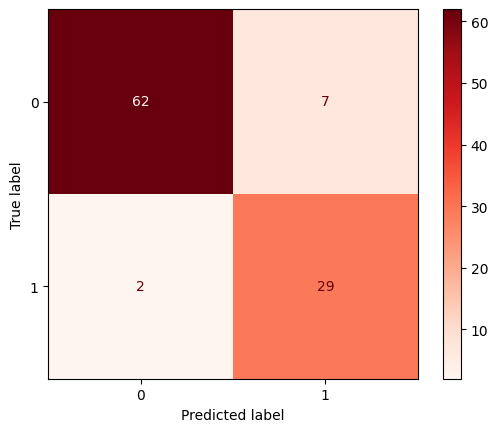

In [ ]:
# Check Performance Model
y_pred_test = ada_clf.predict(X_test_scaled)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(rf, X_test_scaled, y_test, cmap='Reds'))

In [ ]:
# Save Classification Report into a Dictionary

all_reports = performance_report(all_reports, y_train, y_pred_train,
                                 y_test, y_pred_test, 'Baseline AdaBoost (Default Hyperparameter)')
pd.DataFrame(all_reports)

,Baseline RF (Default Hyperparameter),Baseline AdaBoost (Default Hyperparameter)
train - precision,0.844444,0.844444
train - recall,0.678571,0.678571
train - accuracy,0.833333,0.833333
train - f1_score,0.752475,0.752475
test - precision,0.805556,0.827586
test - recall,0.935484,0.774194
test - accuracy_score,0.910000,0.880000
test - f1_score,0.865672,0.800000


Dari hasil diatas, dapat disimpulkan bahwa Random Forest lebih bagus dibandingkan AdaBoost, jika dilihat dari F1 Score pada test-set

# D. Hyperparameter Tuning

Pada tahapan ini untuk menghemat waktu, kita hanya akan mencoba melakukan Hyperparameter Tuning pada Random Forest saja.

## D.1 - Manual Search

In [ ]:
# Hyperparameter Tuning : Manual Search

%%time

rf_ms_1 = RandomForestClassifier(n_estimators=300,
                                 min_samples_leaf=10,
                                 random_state=10)
rf_ms_1.fit(X_train_scaled, y_train)

CPU times: user 809 ms, sys: 13 µs, total: 809 ms
Wall time: 1.57 s


RandomForestClassifier(min_samples_leaf=10, n_estimators=300, random_state=10)

F1 Score - Train Set  :  0.8936170212765958 

Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       188
           1       0.85      0.94      0.89       112

    accuracy                           0.92       300
   macro avg       0.91      0.92      0.91       300
weighted avg       0.92      0.92      0.92       300
 

Confusion Matrix      : 


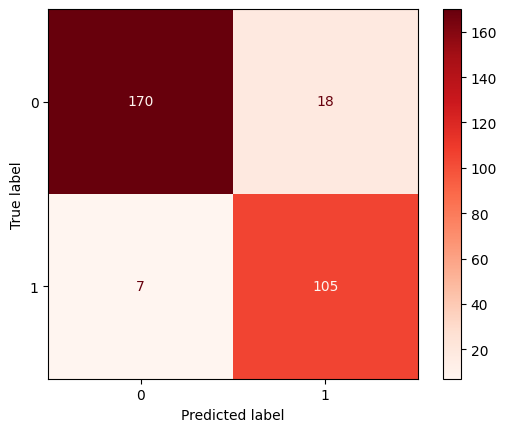

In [ ]:
# Check Performance Model pada Train-Set

y_pred_train = rf_ms_1.predict(X_train_scaled)

print('F1 Score - Train Set  : ', f1_score(y_train, y_pred_train), '\n')
print('Classification Report : \n', classification_report(y_train, y_pred_train), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(rf_ms_1, X_train_scaled, y_train, cmap='Reds'))

In [ ]:
# Cross Validation menggunakan `cross_val_score`

%%time
f1_train_cross_val = cross_val_score(rf_ms_1,
                                     X_train_scaled,
                                     y_train,
                                     cv=3,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.93670886 0.86486486 0.86419753]
F1 Score - Mean - Cross Validation :  0.8885904188295187
F1 Score - Std - Cross Validation  :  0.03402596727984276
F1 Score - Range of Test-Set       :  0.854564451549676 - 0.9226163861093615
CPU times: user 1.36 s, sys: 5.33 ms, total: 1.37 s
Wall time: 1.38 s


Terlihat bahwa mean-accuracy Cross Validation dari model `rf_ms_1` (dengan hyperparameter yang baru) lebih tinggi dibandingkan model `rf` (menggunakan parameter default).

Kita juga dapat berharap bahwa kinerja test-set yang menggunakan` rf_ms_1` lebih tinggi dibandingkan `rf`. Ayo buktikan ini!

F1 Score - Test Set   :  0.8787878787878788 

Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94        69
           1       0.83      0.94      0.88        31

    accuracy                           0.92       100
   macro avg       0.90      0.92      0.91       100
weighted avg       0.93      0.92      0.92       100
 

Confusion Matrix      : 


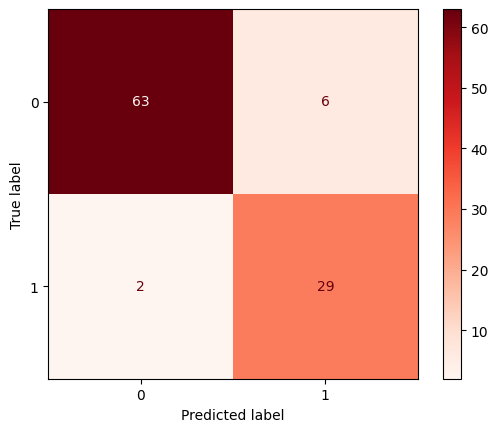

In [ ]:
# Check Performance Model against Test-Set

y_pred_test = rf_ms_1.predict(X_test_scaled)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(rf_ms_1, X_test_scaled, y_test, cmap='Reds'))

In [ ]:
# Save Classification Report into a Dictionary

all_reports = performance_report(all_reports, y_train, y_pred_train,
                                 y_test, y_pred_test, 'Manual Search')
pd.DataFrame(all_reports)

,Baseline RF (Default Hyperparameter),Baseline AdaBoost (Default Hyperparameter),Manual Search
train - precision,0.844444,0.844444,0.853659
train - recall,0.678571,0.678571,0.937500
train - accuracy,0.833333,0.833333,0.916667
train - f1_score,0.752475,0.752475,0.893617
test - precision,0.805556,0.827586,0.828571
test - recall,0.935484,0.774194,0.935484
test - accuracy_score,0.910000,0.880000,0.920000
test - f1_score,0.865672,0.800000,0.878788


Seperti yang dapat kita lihat dari tabel di atas, performa model kami meningkat baik dalam pelatihan maupun pengujian.

Tentu saja kita dapat mencoba hyperparameter lain secara manual dan melakukan Cross Validation. **Namun, bagaimana jika kita ingin mencoba banyak konfigurasi hyperparameter? Haruskah kita memasukkan konfigurasi secara manual dan menjalankannya secara manual**? **Tentu saja TIDAK**. Berikut ini, kami akan menggunakan `RandomSearchCV` dan `GridSearchCV` untuk mengoptimalkan proses ini.

## D.2 - Random Search

In [ ]:
# Hyperparameter Tuning : Random Search
from sklearn.model_selection import RandomizedSearchCV

# Define Hyperparameters
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num = 5)]
max_depth = [int(x) for x in np.linspace(10, 1000, 5)]
min_samples_split = [2, 5, 10, 14]
min_samples_leaf = [1, 2, 4, 6, 8]
random_search_params = {'n_estimators': n_estimators,
                        'max_depth':max_depth,
                        'min_samples_split':min_samples_split,
                        'min_samples_leaf':min_samples_leaf}
random_search_params

{'n_estimators': [200, 650, 1100, 1550, 2000],
 'max_depth': [10, 257, 505, 752, 1000],
 'min_samples_split': [2, 5, 10, 14],
 'min_samples_leaf': [1, 2, 4, 6, 8]}

In [ ]:
# Train with Random Search
%%time

rf_randomcv = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                 param_distributions=random_search_params,
                                 n_iter=20,
                                 cv=5,
                                 random_state=46,
                                 n_jobs=-1, #parallel processing
                                 scoring='f1',
                                 verbose=3)
rf_randomcv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 2.43 s, sys: 450 ms, total: 2.88 s
Wall time: 2min 54s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 257, 505, 752, 1000],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 650, 1100, 1550,
                                                         2000]},
                   random_state=46, scoring='f1', verbose=3)

In [ ]:
# Get Best Hyperparameters

rf_randomcv.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 6,
 'max_depth': 257}

In [ ]:
# Get Best Estimator

rf_randomcv_best = rf_randomcv.best_estimator_

In [ ]:
rf_randomcv_best

RandomForestClassifier(max_depth=257, min_samples_leaf=6, min_samples_split=5,
                       n_estimators=200)

F1 Score - Test Set   :  0.8787878787878788 

Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94        69
           1       0.83      0.94      0.88        31

    accuracy                           0.92       100
   macro avg       0.90      0.92      0.91       100
weighted avg       0.93      0.92      0.92       100
 

Confusion Matrix      : 


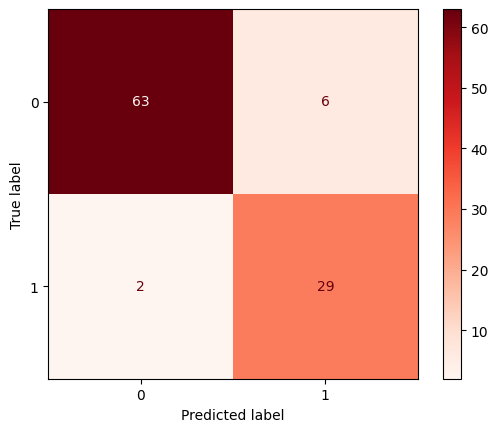

In [ ]:
# Check Performance Model pada Test-Set

y_pred_test = rf_randomcv_best.predict(X_test_scaled)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(rf_randomcv_best, X_test_scaled, y_test, cmap='Reds'))

In [ ]:
# Save Classification Report

all_reports = performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, 'Random Search')
pd.DataFrame(all_reports)

,Baseline RF (Default Hyperparameter),Baseline AdaBoost (Default Hyperparameter),Manual Search,Random Search
train - precision,0.844444,0.844444,0.853659,0.853659
train - recall,0.678571,0.678571,0.937500,0.937500
train - accuracy,0.833333,0.833333,0.916667,0.916667
train - f1_score,0.752475,0.752475,0.893617,0.893617
test - precision,0.805556,0.827586,0.828571,0.828571
test - recall,0.935484,0.774194,0.935484,0.935484
test - accuracy_score,0.910000,0.880000,0.920000,0.920000
test - f1_score,0.865672,0.800000,0.878788,0.878788


## D.3 - Grid Search

In [ ]:
# Hyperparameter Tuning : Grid Search
from sklearn.model_selection import GridSearchCV

# Gunakan kembali hyperparameter terbaik dari RandomSearch untuk efisiensi
grid_search_params = {
    'n_estimators': [rf_randomcv.best_params_['n_estimators'] - 100,
                     rf_randomcv.best_params_['n_estimators'] - 50,
                     rf_randomcv.best_params_['n_estimators'],
                     rf_randomcv.best_params_['n_estimators'] + 50,
                     rf_randomcv.best_params_['n_estimators'] + 100],
    'max_depth': [rf_randomcv.best_params_['max_depth']],
    'min_samples_split': [rf_randomcv.best_params_['min_samples_split'],
                          rf_randomcv.best_params_['min_samples_split'] + 1,
                          rf_randomcv.best_params_['min_samples_split'] + 2],
    'min_samples_leaf': [rf_randomcv.best_params_['min_samples_leaf'],
                         rf_randomcv.best_params_['min_samples_leaf'] + 2,
                         rf_randomcv.best_params_['min_samples_leaf'] + 4],
}

grid_search_params

{'n_estimators': [1000, 1050, 1100, 1150, 1200],
 'max_depth': [752],
 'min_samples_split': [2, 3, 4],
 'min_samples_leaf': [8, 10, 12]}

In [ ]:
# Display Best Hyperparamters dari Random Search

rf_randomcv.best_params_

{'n_estimators': 1100,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_depth': 752}

In [ ]:
# Train dengan Grid Search
%%time

rf_gridcv = GridSearchCV(estimator=RandomForestClassifier(),
                         param_grid=grid_search_params,
                         cv=5,
                         n_jobs=-1,
                         verbose=2,
                         scoring='f1')

rf_gridcv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
CPU times: user 5.05 s, sys: 773 ms, total: 5.82 s
Wall time: 5min 50s


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [752], 'min_samples_leaf': [8, 10, 12],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [1000, 1050, 1100, 1150, 1200]},
             scoring='f1', verbose=2)

In [ ]:
# Get Best Hyperparameters

rf_gridcv.best_params_

{'max_depth': 752,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [ ]:
# Get Best Estimator

rf_gridcv_best = rf_gridcv.best_estimator_

F1 Score - Test Set   :  0.8787878787878788 

Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94        69
           1       0.83      0.94      0.88        31

    accuracy                           0.92       100
   macro avg       0.90      0.92      0.91       100
weighted avg       0.93      0.92      0.92       100
 

Confusion Matrix      : 


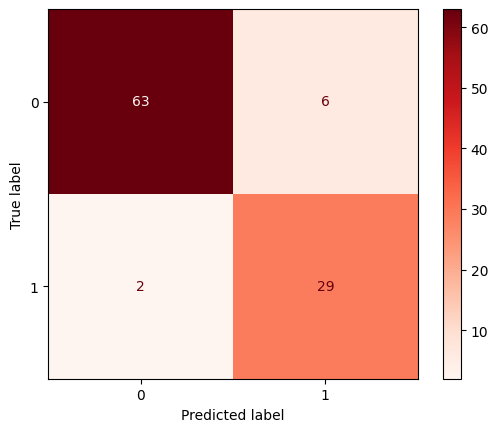

In [ ]:
# Check Performance Model pada Test-Set

y_pred_test = rf_gridcv_best.predict(X_test_scaled)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(rf_gridcv_best, X_test_scaled, y_test, cmap='Reds'))

In [ ]:
# Save Classification Report

all_reports = performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, 'Grid Search')
pd.DataFrame(all_reports)

,Baseline RF (Default Hyperparameter),Baseline AdaBoost (Default Hyperparameter),Manual Search,Random Search,Grid Search
train - precision,0.991071,0.991071,0.853659,0.853659,0.853659
train - recall,0.991071,0.991071,0.937500,0.937500,0.937500
train - accuracy,0.993333,0.993333,0.916667,0.916667,0.916667
train - f1_score,0.991071,0.991071,0.893617,0.893617,0.893617
test - precision,0.800000,0.827586,0.828571,0.828571,0.828571
test - recall,0.903226,0.774194,0.935484,0.935484,0.935484
test - accuracy_score,0.900000,0.880000,0.920000,0.920000,0.920000
test - f1_score,0.848485,0.800000,0.878788,0.878788,0.878788


Meskipun RandomSearchCV dan GridSearchCV menghasilkan performa yang sama, namun `n_estimators` berbeda.

`RandomSearchCV` :
```
'n_estimators': 1100,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_depth': 752
```

`GridSearchCV` :
```
'n_estimators': 1000
'min_samples_split': 2,
'min_samples_leaf': 8,
'max_depth': 752

```